In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import heapq
from typing import Dict, Tuple, List, Optional
import time

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

## Part 1: Tabular Model Implementation

In [2]:
class TabularModel:
    """
    Store observed transitions for model-based planning.
    Uses dictionary to store (s,a) → (r, s') mappings.
    """
    def __init__(self):
        self.model = {}  # (s,a) → (r, s')
        self.visited = set()  # Track visited (s,a) pairs

    def update(self, state: int, action: int, reward: float, next_state: int):
        """Store observed transition."""
        self.model[(state, action)] = (reward, next_state)
        self.visited.add((state, action))

    def sample(self) -> Optional[Tuple[int, int, float, int]]:
        """Sample random previously observed (s,a) pair."""
        if not self.visited:
            return None
        state, action = random.choice(list(self.visited))
        reward, next_state = self.model[(state, action)]
        return state, action, reward, next_state

    def get_transition(self, state: int, action: int) -> Optional[Tuple[float, int]]:
        """Get stored transition for specific (s,a)."""
        return self.model.get((state, action), None)

    def __len__(self):
        return len(self.visited)

## Part 2: Pure Q-Learning (Baseline)

In [3]:
def q_learning(env, num_episodes: int, alpha: float = 0.1,
               gamma: float = 0.99, epsilon: float = 0.1):
    """
    Standard Q-learning algorithm (no planning).

    Args:
        env: Gymnasium environment
        num_episodes: Number of episodes to train
        alpha: Learning rate
        gamma: Discount factor
        epsilon: Exploration rate

    Returns:
        Q: Learned Q-table
        episode_returns: List of episode returns
        steps_per_episode: List of steps per episode
        total_steps: Total environment steps
    """
    # Initialize Q-table
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    def epsilon_greedy(state):
        if np.random.random() < epsilon:
            return env.action_space.sample()
        return np.argmax(Q[state])

    episode_returns = []
    steps_per_episode = []
    total_steps = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_steps = 0
        done = False

        while not done:
            # Select and execute action
            action = epsilon_greedy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            episode_steps += 1
            total_steps += 1

            # Q-learning update
            if not done:
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                td_target = reward

            Q[state, action] += alpha * (td_target - Q[state, action])

            state = next_state

        episode_returns.append(episode_reward)
        steps_per_episode.append(episode_steps)

    return Q, episode_returns, steps_per_episode, total_steps

## Part 3: Dyna-Q Implementation

In [4]:
def dyna_q(env, num_episodes: int, n_planning: int = 5, alpha: float = 0.1,
           gamma: float = 0.99, epsilon: float = 0.1):
    """
    Dyna-Q algorithm: Q-learning + model learning + planning.

    Args:
        env: Gymnasium environment
        num_episodes: Number of episodes to train
        n_planning: Number of planning steps per real step
        alpha: Learning rate
        gamma: Discount factor
        epsilon: Exploration rate

    Returns:
        Q: Learned Q-table
        model: Learned model
        episode_returns: List of episode returns
        steps_per_episode: List of steps per episode
        total_steps: Total environment steps
    """
    # Initialize Q-table and model
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    model = TabularModel()

    def epsilon_greedy(state):
        if np.random.random() < epsilon:
            return env.action_space.sample()
        return np.argmax(Q[state])

    episode_returns = []
    steps_per_episode = []
    total_steps = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_steps = 0
        done = False

        while not done:
            # 1. DIRECT RL: Q-learning update from real experience
            action = epsilon_greedy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            episode_steps += 1
            total_steps += 1

            # Q-learning update
            if not done:
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                td_target = reward

            Q[state, action] += alpha * (td_target - Q[state, action])

            # 2. MODEL LEARNING: Store observed transition
            model.update(state, action, reward, next_state)

            # 3. PLANNING: Simulate experience using model
            for _ in range(n_planning):
                sample = model.sample()
                if sample is None:
                    break

                s_sim, a_sim, r_sim, s_next_sim = sample

                # Simulated Q-learning update
                td_target_sim = r_sim + gamma * np.max(Q[s_next_sim])
                Q[s_sim, a_sim] += alpha * (td_target_sim - Q[s_sim, a_sim])

            state = next_state

        episode_returns.append(episode_reward)
        steps_per_episode.append(episode_steps)

    return Q, model, episode_returns, steps_per_episode, total_steps

## Part 4: Experiment 1 - Compare Q-Learning vs Dyna-Q

In [5]:
def run_comparison_experiment(num_episodes: int = 500, num_runs: int = 5):
    """
    Compare Q-learning vs Dyna-Q with different planning steps.
    """
    env = gym.make('Taxi-v3')
    planning_steps = [0, 5, 10, 50]  # 0 = pure Q-learning

    results = {n: {'returns': [], 'steps': [], 'total_steps': []}
               for n in planning_steps}

    print("Running comparison experiments...")
    for n in planning_steps:
        print(f"\nTesting n={n} planning steps...")
        for run in range(num_runs):
            if n == 0:
                Q, returns, steps, total = q_learning(
                    env, num_episodes, alpha=0.1, gamma=0.99, epsilon=0.1
                )
            else:
                Q, model, returns, steps, total = dyna_q(
                    env, num_episodes, n_planning=n,
                    alpha=0.1, gamma=0.99, epsilon=0.1
                )

            results[n]['returns'].append(returns)
            results[n]['steps'].append(steps)
            results[n]['total_steps'].append(total)

            print(f"  Run {run+1}/{num_runs} complete")

    env.close()
    return results

In [6]:
results = run_comparison_experiment(num_episodes=500, num_runs=5)
print("\nExperiments complete!")

Running comparison experiments...

Testing n=0 planning steps...
  Run 1/5 complete
  Run 2/5 complete
  Run 3/5 complete
  Run 4/5 complete
  Run 5/5 complete

Testing n=5 planning steps...
  Run 1/5 complete
  Run 2/5 complete
  Run 3/5 complete
  Run 4/5 complete
  Run 5/5 complete

Testing n=10 planning steps...
  Run 1/5 complete
  Run 2/5 complete
  Run 3/5 complete
  Run 4/5 complete
  Run 5/5 complete

Testing n=50 planning steps...
  Run 1/5 complete
  Run 2/5 complete
  Run 3/5 complete
  Run 4/5 complete
  Run 5/5 complete

Experiments complete!


## Part 5: Visualization - Learning Curves

In [7]:
def smooth(data, window=10):
    """Apply moving average smoothing."""
    if len(data) < window:
        return data
    return np.convolve(data, np.ones(window)/window, mode='valid')

In [8]:
def plot_learning_curves(results):
    """Plot learning curves for different planning steps."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    planning_steps = [0, 5, 10, 50]
    colors = ['blue', 'green', 'orange', 'red']

    # Plot 1: Episode Returns over Episodes
    ax = axes[0, 0]
    for n, color in zip(planning_steps, colors):
        returns_array = np.array(results[n]['returns'])
        mean_returns = returns_array.mean(axis=0)
        std_returns = returns_array.std(axis=0)

        smoothed_mean = smooth(mean_returns, window=20)
        episodes = range(len(smoothed_mean))

        label = 'Q-learning' if n == 0 else f'Dyna-Q (n={n})'
        ax.plot(episodes, smoothed_mean, color=color, label=label, linewidth=2)

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Average Return (smoothed)', fontsize=12)
    ax.set_title('Learning Curves: Returns vs Episodes', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Cumulative Reward over Time Steps
    ax = axes[0, 1]
    for n, color in zip(planning_steps, colors):
        returns_array = np.array(results[n]['returns'])
        steps_array = np.array(results[n]['steps'])

        # Calculate cumulative reward vs real steps
        mean_returns = returns_array.mean(axis=0)
        mean_steps = steps_array.mean(axis=0)

        cumulative_steps = np.cumsum(mean_steps)
        cumulative_reward = np.cumsum(mean_returns)

        label = 'Q-learning' if n == 0 else f'Dyna-Q (n={n})'
        ax.plot(cumulative_steps, cumulative_reward, color=color, label=label, linewidth=2)

    ax.set_xlabel('Real Environment Steps', fontsize=12)
    ax.set_ylabel('Cumulative Reward', fontsize=12)
    ax.set_title('Sample Efficiency: Cumulative Reward vs Steps', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Steps per Episode (convergence speed)
    ax = axes[1, 0]
    for n, color in zip(planning_steps, colors):
        steps_array = np.array(results[n]['steps'])
        mean_steps = steps_array.mean(axis=0)

        smoothed_steps = smooth(mean_steps, window=20)
        episodes = range(len(smoothed_steps))

        label = 'Q-learning' if n == 0 else f'Dyna-Q (n={n})'
        ax.plot(episodes, smoothed_steps, color=color, label=label, linewidth=2)

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Steps per Episode (smoothed)', fontsize=12)
    ax.set_title('Convergence Speed: Steps to Complete Episode', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Episodes to reach good performance
    ax = axes[1, 1]
    threshold = 7  # Good performance threshold for Taxi-v3
    episodes_to_threshold = []

    for n in planning_steps:
        returns_array = np.array(results[n]['returns'])
        mean_returns = returns_array.mean(axis=0)

        # Find first episode where smoothed return > threshold
        smoothed = smooth(mean_returns, window=20)
        idx = np.where(smoothed > threshold)[0]

        if len(idx) > 0:
            episodes_to_threshold.append(idx[0])
        else:
            episodes_to_threshold.append(len(mean_returns))

    labels = ['Q-learning', 'Dyna-Q (n=5)', 'Dyna-Q (n=10)', 'Dyna-Q (n=50)']
    bars = ax.bar(labels, episodes_to_threshold, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Episodes to Reach Threshold', fontsize=12)
    ax.set_title(f'Sample Efficiency: Episodes to Reach Return > {threshold}',
                 fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, val in zip(bars, episodes_to_threshold):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(val)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('dyna_q_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

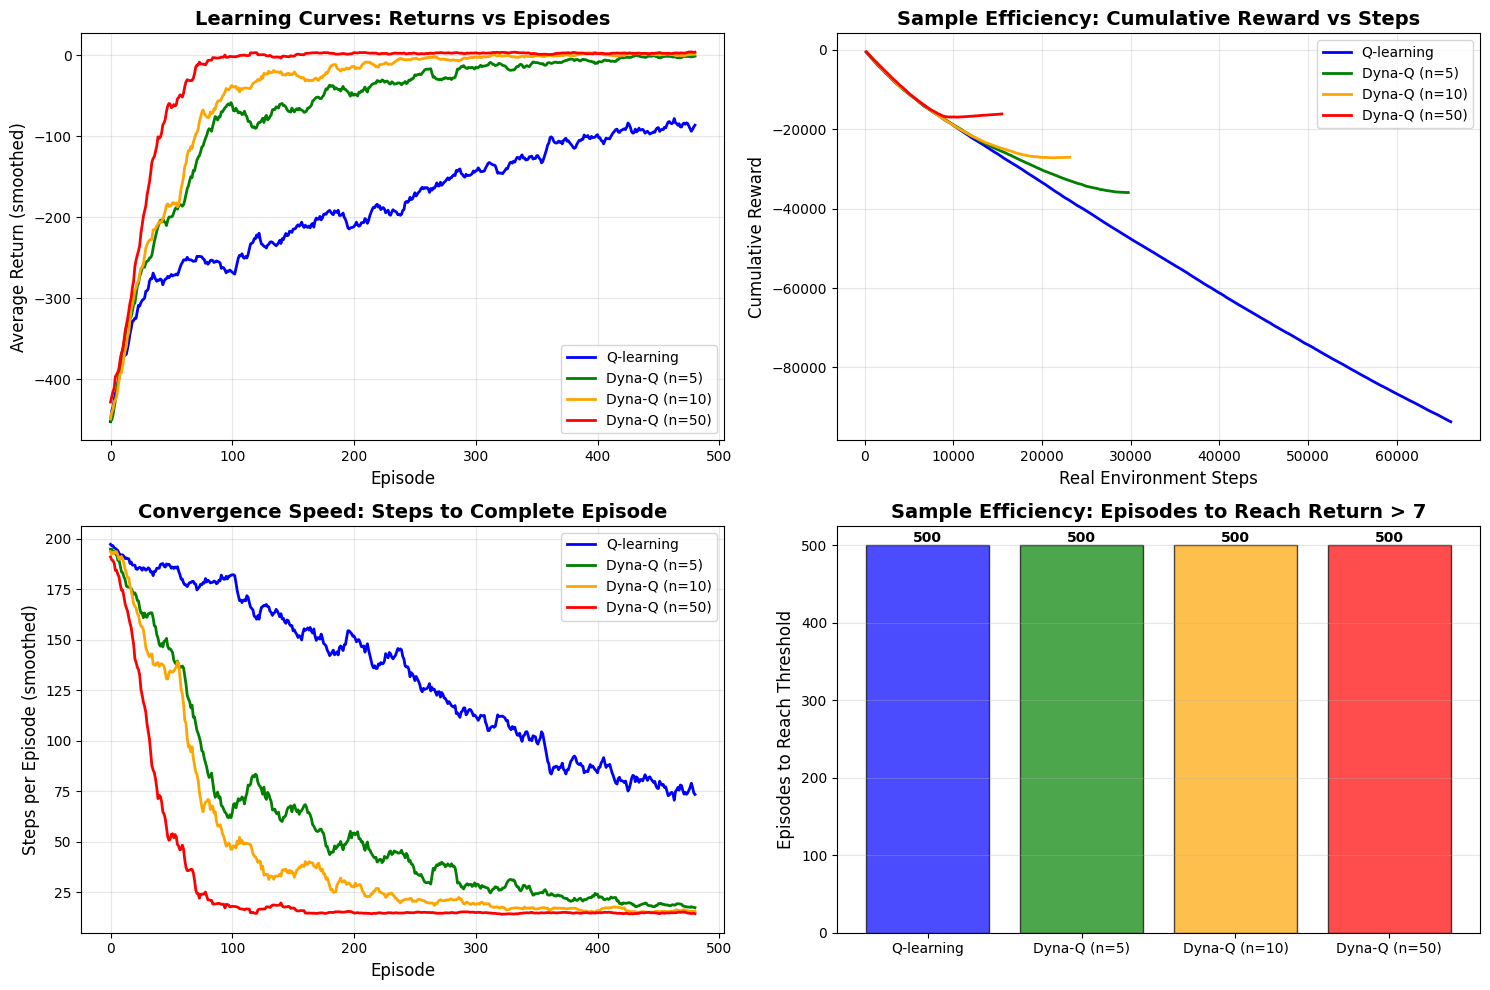

In [9]:
plot_learning_curves(results)


## Part 6: Dynamic Environment Wrapper

In [10]:
class DynamicTaxiWrapper(gym.Wrapper):
    """
    Wrapper that changes the Taxi environment after a certain number of steps.
    Simulates a dynamic environment where the optimal policy changes.
    """
    def __init__(self, env, change_step: int = 1000):
        super().__init__(env)
        self.change_step = change_step
        self.total_steps = 0
        self.changed = False

        # Store original locations
        self.original_locs = [(0,0), (0,4), (4,0), (4,3)]  # R, G, Y, B

    def step(self, action):
        self.total_steps += 1

        # Trigger environment change at specific step
        if self.total_steps == self.change_step and not self.changed:
            print(f"\n{'='*60}")
            print(f"ENVIRONMENT CHANGE at step {self.total_steps}!")
            print(f"{'='*60}\n")
            self.changed = True
            # In real implementation, could modify the underlying environment
            # For Taxi-v3, we'll simulate by giving misleading rewards initially

        obs, reward, terminated, truncated, info = self.env.step(action)

        # After change, add noise to simulate environment shift
        if self.changed and np.random.random() < 0.1:
            reward = reward - 5  # Occasionally give worse reward to simulate change

        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


## Part 7: Dyna-Q+ with Exploration Bonuses


In [11]:
def dyna_q_plus(env, num_episodes: int, n_planning: int = 5,
                alpha: float = 0.1, gamma: float = 0.99, epsilon: float = 0.1,
                kappa: float = 0.001):
    """
    Dyna-Q+ algorithm with exploration bonuses for handling dynamic environments.

    Args:
        kappa: Exploration bonus coefficient (κ)

    Returns:
        Q: Learned Q-table
        model: Learned model
        episode_returns: List of episode returns
        time_since: Dictionary tracking time since last visit
    """
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    model = TabularModel()
    time_since = defaultdict(int)  # (s,a) → steps since last real visit

    def epsilon_greedy(state):
        if np.random.random() < epsilon:
            return env.action_space.sample()
        return np.argmax(Q[state])

    episode_returns = []
    steps_per_episode = []
    total_steps = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_steps = 0
        done = False

        while not done:
            # Direct RL
            action = epsilon_greedy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            episode_steps += 1
            total_steps += 1

            # Q-learning update
            if not done:
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                td_target = reward

            Q[state, action] += alpha * (td_target - Q[state, action])

            # Model learning
            model.update(state, action, reward, next_state)

            # Reset time since visit for this (s,a)
            time_since[(state, action)] = 0

            # Increment time since visit for all other (s,a) pairs
            for key in list(time_since.keys()):
                if key != (state, action):
                    time_since[key] += 1

            # Planning with exploration bonuses
            for _ in range(n_planning):
                sample = model.sample()
                if sample is None:
                    break

                s_sim, a_sim, r_sim, s_next_sim = sample

                # Add exploration bonus: κ√τ
                tau = time_since.get((s_sim, a_sim), 0)
                exploration_bonus = kappa * np.sqrt(tau)

                # Simulated Q-learning update with bonus
                td_target_sim = (r_sim + exploration_bonus) + gamma * np.max(Q[s_next_sim])
                Q[s_sim, a_sim] += alpha * (td_target_sim - Q[s_sim, a_sim])

            state = next_state

        episode_returns.append(episode_reward)
        steps_per_episode.append(episode_steps)

    return Q, model, episode_returns, steps_per_episode, time_since


## Part 8: Dynamic Environment Experiment


In [12]:
def run_dynamic_environment_experiment(num_episodes: int = 1000,
                                       change_step: int = 500):
    """
    Compare Dyna-Q vs Dyna-Q+ in a dynamic environment.
    """
    results = {}

    # Test Dyna-Q (without exploration bonuses)
    print("Testing Dyna-Q in dynamic environment...")
    env = DynamicTaxiWrapper(gym.make('Taxi-v3'), change_step=change_step)
    Q, model, returns, steps, time_since = dyna_q(
        env, num_episodes, n_planning=10, alpha=0.1, gamma=0.99, epsilon=0.1
    )
    results['dyna_q'] = {'returns': returns, 'steps': steps}
    env.close()

    # Test Dyna-Q+ (with exploration bonuses)
    print("Testing Dyna-Q+ in dynamic environment...")
    env = DynamicTaxiWrapper(gym.make('Taxi-v3'), change_step=change_step)
    Q_plus, model_plus, returns_plus, steps_plus, time_since_plus = dyna_q_plus(
        env, num_episodes, n_planning=10, alpha=0.1, gamma=0.99,
        epsilon=0.1, kappa=0.001
    )
    results['dyna_q_plus'] = {'returns': returns_plus, 'steps': steps_plus}
    env.close()

    return results, change_step

# Run dynamic environment experiment
dynamic_results, change_step = run_dynamic_environment_experiment(
    num_episodes=1000, change_step=500
)

Testing Dyna-Q in dynamic environment...

ENVIRONMENT CHANGE at step 500!

Testing Dyna-Q+ in dynamic environment...

ENVIRONMENT CHANGE at step 500!



## Part 9: Visualize Dynamic Environment Results


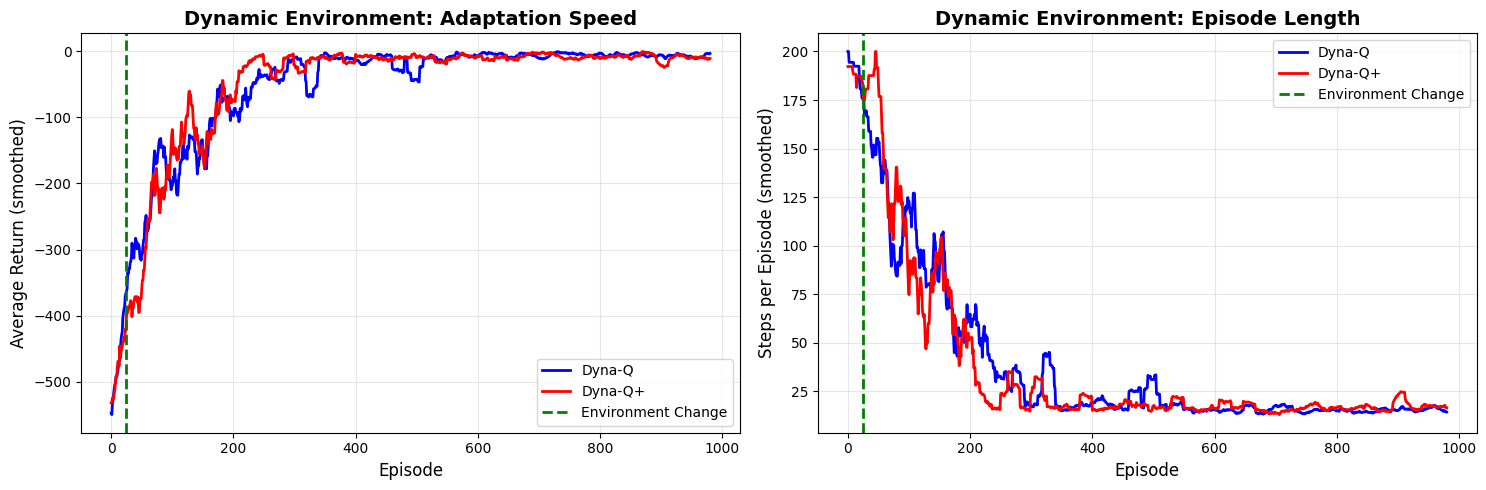

In [13]:
def plot_dynamic_results(results, change_step):
    """Plot comparison of Dyna-Q vs Dyna-Q+ in dynamic environment."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Returns over episodes
    ax = axes[0]

    dyna_returns = smooth(results['dyna_q']['returns'], window=20)
    dyna_plus_returns = smooth(results['dyna_q_plus']['returns'], window=20)

    episodes = range(len(dyna_returns))

    ax.plot(episodes, dyna_returns, color='blue', label='Dyna-Q', linewidth=2)
    ax.plot(episodes, dyna_plus_returns, color='red', label='Dyna-Q+', linewidth=2)
    ax.axvline(x=change_step//20, color='green', linestyle='--',
               linewidth=2, label='Environment Change')

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Average Return (smoothed)', fontsize=12)
    ax.set_title('Dynamic Environment: Adaptation Speed', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Steps per episode (lower is better)
    ax = axes[1]

    dyna_steps = smooth(results['dyna_q']['steps'], window=20)
    dyna_plus_steps = smooth(results['dyna_q_plus']['steps'], window=20)

    episodes = range(len(dyna_steps))

    ax.plot(episodes, dyna_steps, color='blue', label='Dyna-Q', linewidth=2)
    ax.plot(episodes, dyna_plus_steps, color='red', label='Dyna-Q+', linewidth=2)
    ax.axvline(x=change_step//20, color='green', linestyle='--',
               linewidth=2, label='Environment Change')

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Steps per Episode (smoothed)', fontsize=12)
    ax.set_title('Dynamic Environment: Episode Length', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('dynamic_environment_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_dynamic_results(dynamic_results, change_step)

## Part 10: Prioritized Sweeping Implementation


In [14]:
class PrioritizedSweeping:
    """
    Prioritized sweeping using a priority queue.
    Priorities based on magnitude of expected TD error.
    """
    def __init__(self, theta: float = 0.01):
        self.pqueue = []  # Min heap: (priority, state, action)
        self.theta = theta  # Priority threshold
        self.predecessors = defaultdict(set)  # s' → set of (s, a) that lead to s'
        self.counter = 0  # For tie-breaking in heap

    def add_predecessor(self, state: int, action: int, next_state: int):
        """Track which (s,a) pairs lead to next_state."""
        self.predecessors[next_state].add((state, action))

    def insert(self, priority: float, state: int, action: int):
        """Insert (s,a) pair with given priority (use negative for max-heap)."""
        if priority > self.theta:
            # Use negative priority for max-heap behavior
            # Add counter for stable sorting
            heapq.heappush(self.pqueue, (-priority, self.counter, state, action))
            self.counter += 1

    def pop(self) -> Optional[Tuple[int, int, float]]:
        """Pop highest priority (s,a) pair."""
        if not self.pqueue:
            return None
        neg_priority, _, state, action = heapq.heappop(self.pqueue)
        return state, action, -neg_priority

    def is_empty(self) -> bool:
        return len(self.pqueue) == 0

    def __len__(self):
        return len(self.pqueue)


In [15]:
def dyna_q_prioritized(env, num_episodes: int, n_planning: int = 5,
                       alpha: float = 0.1, gamma: float = 0.99,
                       epsilon: float = 0.1, theta: float = 0.01):
    """
    Dyna-Q with prioritized sweeping instead of random sampling.

    Args:
        theta: Priority threshold for adding to queue
    """
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    model = TabularModel()
    pqueue = PrioritizedSweeping(theta=theta)

    def epsilon_greedy(state):
        if np.random.random() < epsilon:
            return env.action_space.sample()
        return np.argmax(Q[state])

    episode_returns = []
    steps_per_episode = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_steps = 0
        done = False

        while not done:
            # Direct RL
            action = epsilon_greedy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            episode_steps += 1

            # Model learning
            model.update(state, action, reward, next_state)
            pqueue.add_predecessor(state, action, next_state)

            # Calculate priority (magnitude of TD error)
            if not done:
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                td_target = reward

            priority = abs(td_target - Q[state, action])

            # Add to priority queue if priority exceeds threshold
            pqueue.insert(priority, state, action)

            # Planning: process highest priority updates
            for _ in range(n_planning):
                if pqueue.is_empty():
                    break

                s_plan, a_plan, p = pqueue.pop()

                # Get transition from model
                transition = model.get_transition(s_plan, a_plan)
                if transition is None:
                    continue

                r_plan, s_next_plan = transition

                # Q-learning update
                td_target_plan = r_plan + gamma * np.max(Q[s_next_plan])
                Q[s_plan, a_plan] += alpha * (td_target_plan - Q[s_plan, a_plan])

                # Update predecessors
                for s_pred, a_pred in pqueue.predecessors[s_plan]:
                    transition_pred = model.get_transition(s_pred, a_pred)
                    if transition_pred is None:
                        continue

                    r_pred, s_next_pred = transition_pred

                    # Calculate priority for predecessor
                    td_target_pred = r_pred + gamma * np.max(Q[s_next_pred])
                    priority_pred = abs(td_target_pred - Q[s_pred, a_pred])

                    # Add predecessor to queue if priority exceeds threshold
                    pqueue.insert(priority_pred, s_pred, a_pred)

            state = next_state

        episode_returns.append(episode_reward)
        steps_per_episode.append(episode_steps)

    return Q, model, episode_returns, steps_per_episode


## Part 11: Compare Random vs Prioritized Planning


In [16]:
def run_prioritized_experiment(num_episodes: int = 500, num_runs: int = 3):
    """Compare random planning vs prioritized sweeping."""
    results = {'random': [], 'prioritized': []}

    print("Comparing random planning vs prioritized sweeping...")

    for run in range(num_runs):
        print(f"\nRun {run+1}/{num_runs}")

        # Random planning (standard Dyna-Q)
        print("  Testing random planning...")
        env = gym.make('Taxi-v3')
        Q, model, returns, steps, total = dyna_q(
            env, num_episodes, n_planning=10, alpha=0.1, gamma=0.99, epsilon=0.1
        )
        results['random'].append(returns)
        env.close()

        # Prioritized sweeping
        print("  Testing prioritized sweeping...")
        env = gym.make('Taxi-v3')
        Q_p, model_p, returns_p, steps_p = dyna_q_prioritized(
            env, num_episodes, n_planning=10, alpha=0.1, gamma=0.99,
            epsilon=0.1, theta=0.01
        )
        results['prioritized'].append(returns_p)
        env.close()

    return results

# Run prioritized sweeping experiment
prioritized_results = run_prioritized_experiment(num_episodes=500, num_runs=3)


Comparing random planning vs prioritized sweeping...

Run 1/3
  Testing random planning...
  Testing prioritized sweeping...

Run 2/3
  Testing random planning...
  Testing prioritized sweeping...

Run 3/3
  Testing random planning...
  Testing prioritized sweeping...


## Part 12: Visualize Prioritized Sweeping Results


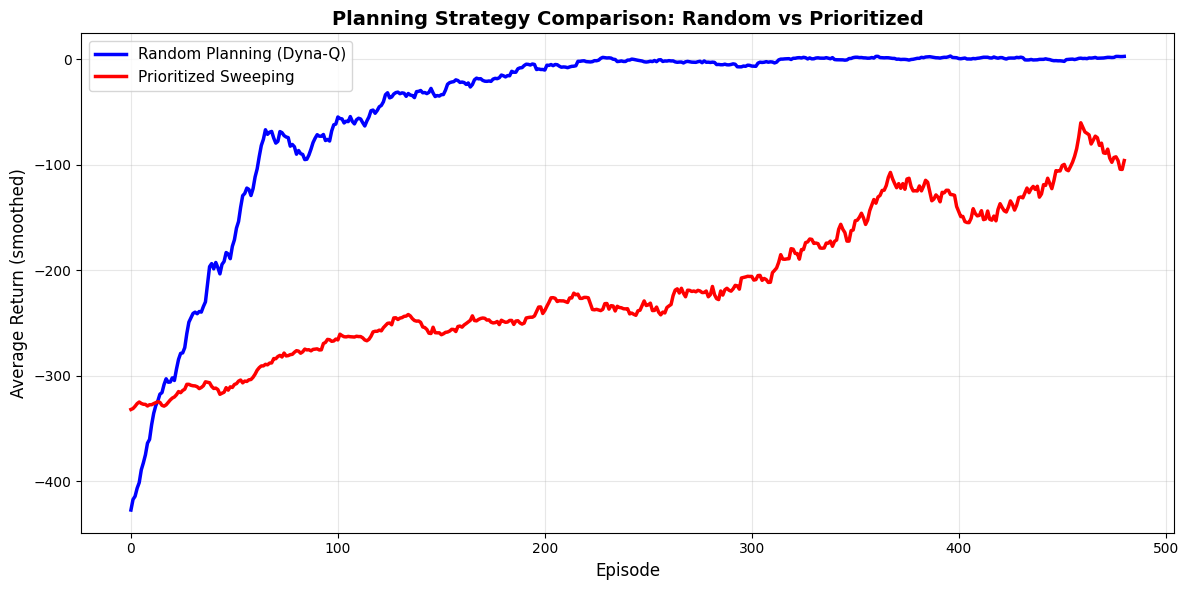

In [17]:
def plot_prioritized_comparison(results):
    """Plot comparison of random vs prioritized planning."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Calculate mean and std
    random_array = np.array(results['random'])
    prioritized_array = np.array(results['prioritized'])

    random_mean = random_array.mean(axis=0)
    prioritized_mean = prioritized_array.mean(axis=0)

    random_smoothed = smooth(random_mean, window=20)
    prioritized_smoothed = smooth(prioritized_mean, window=20)

    episodes = range(len(random_smoothed))

    ax.plot(episodes, random_smoothed, color='blue',
            label='Random Planning (Dyna-Q)', linewidth=2.5)
    ax.plot(episodes, prioritized_smoothed, color='red',
            label='Prioritized Sweeping', linewidth=2.5)

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Average Return (smoothed)', fontsize=12)
    ax.set_title('Planning Strategy Comparison: Random vs Prioritized',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('prioritized_sweeping_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_prioritized_comparison(prioritized_results)

## Part 13: Analysis and Synthesis


In [18]:
print("ANALYSIS: Model-Based vs Model-Free Trade-offs")
print("="*70)

# Calculate sample efficiency metrics
planning_steps = [0, 5, 10, 50]

print("\n1. SAMPLE EFFICIENCY ANALYSIS")
print("-" * 70)
for n in planning_steps:
    total_steps = np.mean(results[n]['total_steps'])
    returns_array = np.array(results[n]['returns'])
    final_performance = returns_array.mean(axis=0)[-50:].mean()

    label = "Q-learning" if n == 0 else f"Dyna-Q (n={n})"
    print(f"{label:20s} | Final Performance: {final_performance:6.2f} | "
          f"Total Steps: {total_steps:8.0f}")

print("\n2. COMPUTATIONAL COST ANALYSIS")
print("-" * 70)
print("Per Real Environment Step:")
for n in planning_steps:
    updates_per_step = 1 + n  # 1 real update + n planning updates
    label = "Q-learning" if n == 0 else f"Dyna-Q (n={n})"
    print(f"{label:20s} | Q-table Updates: {updates_per_step:3d} | "
          f"Relative Cost: {updates_per_step:3d}x")


ANALYSIS: Model-Based vs Model-Free Trade-offs

1. SAMPLE EFFICIENCY ANALYSIS
----------------------------------------------------------------------
Q-learning           | Final Performance: -85.96 | Total Steps:    66081
Dyna-Q (n=5)         | Final Performance:  -1.98 | Total Steps:    29731
Dyna-Q (n=10)        | Final Performance:   0.78 | Total Steps:    23130
Dyna-Q (n=50)        | Final Performance:   2.93 | Total Steps:    15471

2. COMPUTATIONAL COST ANALYSIS
----------------------------------------------------------------------
Per Real Environment Step:
Q-learning           | Q-table Updates:   1 | Relative Cost:   1x
Dyna-Q (n=5)         | Q-table Updates:   6 | Relative Cost:   6x
Dyna-Q (n=10)        | Q-table Updates:  11 | Relative Cost:  11x
Dyna-Q (n=50)        | Q-table Updates:  51 | Relative Cost:  51x
